# TensorFlow实现自编码器

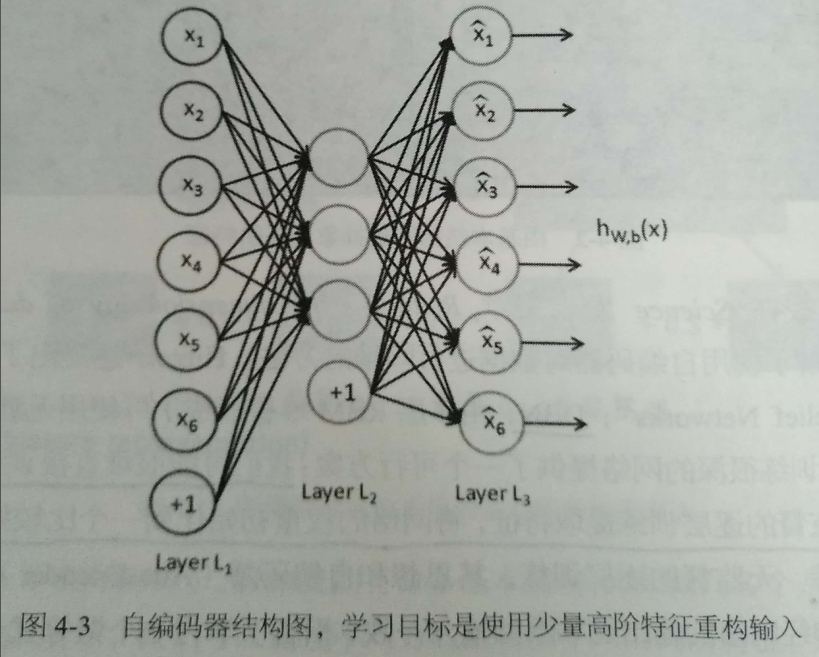

In [34]:
# 导入库
import numpy as np
import sklearn.preprocessing as prep
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

## 实现xavier初始化器

xavier的特点是会根据某一层网络的输入、输出节点数自动调整最合适的分布。相关论文指出，如果深度学习模型的权重初始化太小，信号将在每层传递逐渐缩小而难以产生作用；如果权重初始化太大，信号将在每层传递时放大并导致发散和失效。而Xavier初始化器做的事情就是要让权重初始化不大不小，正好合适。

从数学的角度分析，Xavier是让权重满足 $0$ 的均值，同时方差为 $\frac{2}{n_{in}+n_{out}}$ ,分布可以用均匀分布或者高斯分布。

如下代码所示，我们通过tf.random_uniform创建了一个 $(-\sqrt{\frac{6}{n_{in}+n_{out}}}, \sqrt{\frac{6}{n_{in}+n_{out}}})$ 范围内的均匀分布，而它的方差根据公式 $D(x)=(max-min)^2/12$刚好等于 $\frac{2}{n_{in}+n_{out}}$ 。因此这里实现的是标准额均匀分布Xavier。

In [35]:
def xavier_init(fan_in, fan_out, constant=1):
    '''
    实现标准均匀分布的Xavier初始化器
    fan_in:是输入节点的变量
    fan_out:是输出节点的变量
    constant:是系数
    '''
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval = low, 
                             maxval = high, 
                             dtype = tf.float32)

In [36]:
# 加载数据集
mnist = input_data.read_data_sets("../datasets/MNIST_data/", one_hot=True)


Extracting ../datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


## 定义一个去噪的自编码class

In [37]:
# 定义一个去噪自编码的class
class AdditiveGaussianNoiseAutoencoder(object):
    # 定义__init__函数
    def __init__(self, n_input, n_hidden, transfer_function=tf.nn.softplus,
                optimizer = tf.train.AdamOptimizer(), scale = 0.1):
        '''
        n_input:输入变量数
        n_hidden:隐含层节点数
        transfer_function:隐含层激活函数
        optimizer:优化器
        scale:高斯噪声系数
        '''
        self.n_input = n_input # 输入层节点数
        self.n_hidden = n_hidden # 隐含层节点数
        self.transfer = transfer_function # 激活函数
        self.scale = tf.placeholder(tf.float32) # 
        self.training_scale = scale # 高斯噪声系数
        network_weights = self._initialize_weights() # 产生网络的权重
        self.weights = network_weights # 网络的权重系数
        
        # 开始定义网络结构
        # 我们为输入x 创建一个维度为n_input的placeholder
        # self.x定义了输入层的数据
        self.x = tf.placeholder(tf.float32, shape=[None, self.n_input])
        
        # 然后建立一个能提取特征的隐含层
        # 先将输入数据x加上噪声，即self.x + scale * tf.trandom_normal((n_input))
        # 然后用tf.matmul将加了噪声的输入与隐含层的权重w1相乘，并使用tf.add加上隐含层的偏置b1
        # 最后使用self.transfer对结果进行激活函数处理
        self.hidden = self.transfer(tf.add(tf.matmul(self.x + scale*tf.random_normal((n_input,)),
                                                     self.weights['w1']), 
                                           self.weights['b1']))
        # 经过隐含层之后，我们需要在输出层进行数据复原、重建操作(即建立reconstruction层)，
        # 这里我们就不使用激活函数了，直接将隐含层的输出self.hidden乘上输出层的权重w2,
        # 再加上输出层的偏置b2
        self.reconstruction = tf.add(tf.matmul(self.hidden, self.weights['w2']), self.weights['b2'])
        
        # 接下来定自编码器的损失函数
        # 这里直接使用平方差作为cost
        # 首先用tf.subtract计算输出(tf.reconstruction)与输入self.x的差
        # 使用tf.pow求差的平方
        # 最后使用tf.reduce_sum求和，即可得平方差
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)
        
        # 定义变量初始化操作
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)
        

    # 定义权重初始化函数
    def _initialize_weights(self):
        '''
        首先创建一个名为all_weights的dict，然后w1,b1,w2,b2全部存入其中，最后返回all_weights.
        其中,w1需要使用前面定义的xavier_init函数定义，我们直接传入节点数和隐含层节点数。然后,xavier
        即可返回一个比较适合于softplus的等激活函数的权重分布。而偏置b1只需要使用tf.zeros全部置0即可
        对输出层self.reconstruction，因为没有使用激活函数，这里将w2,b2全部置为0
        '''
        all_weights = dict()
        all_weights['w1'] = tf.Variable(xavier_init(self.n_input, self.n_hidden))
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype=tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype=tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype=tf.float32))
        
        return all_weights
    
    
    def partial_fit(self, X):
        '''
        定义计算损失cost和执行一步训练函数partial_fit。
        函数里只需让Session执行两个计算图的节点，分别是损失cost和训练过程optimizer
        输入的feed_dict包括输入数据x，以及噪声的系数scale。
        函数partial_fit做的就是用一个batch数据进行训练并返回当前损失cost
        '''
        cost, opt = self.sess.run((self.cost, self.optimizer), 
                                  feed_dict = {self.x: X, self.scale:self.training_scale})
        
    # 定义只求损失的cost函数
    def calc_total_cost(self, X):
        '''
        这里只让Session执行一个计算图中的节点self.cost，传入的参数与partial_fit中的一致
        这个函数是在自编码器训练完毕之后，在测试集上对模型进行评测时会用到，它不会像partial_fit
        一样触发训练操作
        '''
        return self.sess.run(self.cost, feed_dict={self.x:X, self.scale:self.training_scale})
    
    # 定义transform函数返回自编码器隐含层的输出结果
    def transform(self, x):
        '''
        返回自编码器隐含层的输出结果
        它的目的是提供一接口来获取抽象后的特征，自编码器的隐含层最主要的功能就是学习出数据中的高阶特征
        '''
        return self.sess.run(self.hidden, feed_dict={self.x:X, self.scale:self.training_scale})
    
    def generate(self, hidden=None):
        '''
        它将隐含层的结果作为输入，通过之后的重建层将提取到的高阶特征复原为原始数据。
        这个接口正好和前面的transform接口将整个自编码器拆分为两部分
        这里的generate接口是后半部分将高阶特征复原为原始数据的步骤
        '''
        if hidden is None:
            hidden = np.random_normal(size=self.weights["b1"])
        return self.sess.run(self.reconstruction, feed_dict={self.hidden:hidden})
    
    def reconstruct(self, X):
        '''
        它整体运行一遍复原过程，包括提取高阶特征和通过高阶特征复原数据，既包括transform
        和generate两块。输入数据是原始数据，输出数据是复原后的数据
        '''
        return self.sess.run(self.reconstruction, feed_dict={self.x:X, self.scale:self.training_scale})
    
    def getWeughts(self):
        '''
        这里的getWeights函数作用是获取隐含层的权重w1
        '''
        return self.sess.run(self.weights['w1'])
    
    def getBiases(self):
        '''
        获取隐含层偏置系数b1
        '''
        return self.sess.run(self.weights['b1'])

In [38]:
def standard_scale(X_train, X_test):
    '''
    这个函数对训练、测试集进行标准化处理。
    标准化，即是让数据变成0均值且标准差为1的分布。方法就是先减去均值，再除以标准差。我们直接使用
    sklearn.preprocessing的StandardScaler这个类，先在训练集上进行fit，再将这个Scaler用到训练
    数据或者测试数据上。这里需要注意的是，必须保证训练集、测试数据使用完全相同的的Scaler，这样
    才能保证后面模型处理数据时的一致性，这也就是为什么现在训练数据上fit出一个共用的Scaler的原因
    '''
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test

In [39]:
def get_random_block_from(data, batch_size):
    '''
    定义一个获取随机block数据的函数:取一个从0到len(data)-batch_size之间的随机整数，再以这个随机整数作为block
    的起始位置，然后顺序取到一个batch_size的数据。需要注意的是，这属于不放回抽样，可以提高数据的利用率。
    '''
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)]

In [40]:
# 使用之前的standard_scale函数对训练集、测试集进行标准化变换
X_train, X_test = standard_scale(mnist.train.images, mnist.test.images)

# 几个常用的函数
n_samples = int(mnist.train.num_examples) # 定义总训练样本数
training_epochs = 20 # 最大的训练轮数
batch_size = 128 # batch_size的大小
display_step = 1 # 设置每个一轮(epoch)显示一次cost

In [41]:
# 创建一个AGN自编码器
autoencoder = AdditiveGaussianNoiseAutoencoder(n_input=784,
                                              n_hidden = 200,
                                              transfer_function = tf.nn.softplus,
                                              optimizer = tf.train.AdamOptimizer(learning_rate=0.001),
                                              scale = 0.01)